In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM , Dropout
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

Using TensorFlow backend.


**loading data into dataframe and setting timestamp as index of the dataframe.**

In [2]:
df = pd.read_csv('psi_df_2016_2019.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp' , inplace=True)

**checking if dataframe has null values or not and if that's true, drop them.**

In [3]:
df = df.dropna()
df.isna().sum()

national    0
south       0
north       0
east        0
central     0
west        0
dtype: int64

**Visualizing raw data**

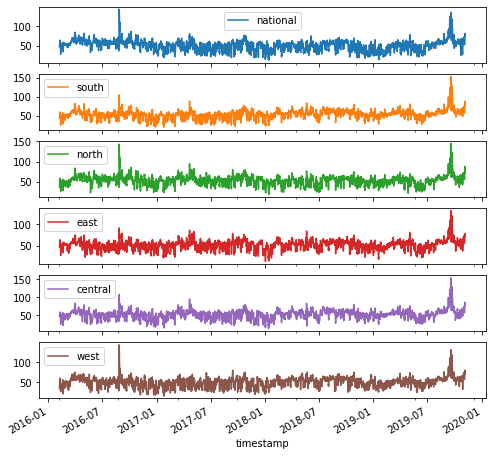

In [4]:
df.plot(subplots=True, figsize=(8, 8));

**Transforming dataframe values(Pm2.5 concentration) by scaling each of them into the range of (0,1).**

In [5]:
scaler = MinMaxScaler()
scaled_df =scaler.fit_transform(df.values)
scaled_df = pd.DataFrame(scaled_df, index= df.index , columns = df.columns)

**Splitting data into 80% of train and 20% of test and turnning them into numpy arrays and also setting sequence length for this matter.**

In [6]:
seq_len = 23 
X_train = []
y_train = []
scaled_df_values = scaled_df.values
for i in range(seq_len, len(scaled_df_values)):
    X_train.append(scaled_df_values[i-seq_len : i, : ])
    y_train.append(scaled_df_values[i, :])

train_size = int(0.8 * len(scaled_df_values))

X_test = X_train[train_size: ]             
y_test = y_train[train_size: ]
  
X_train = X_train[:train_size ]           
y_train = y_train[:train_size ]
    
X_train  = np.array(X_train)
y_train  = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

**Reshape X_data for inputting into RNN.**

In [7]:
X_train = np.reshape(X_train, (train_size, seq_len, 6))
    
X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 6))

**Printing X_data and y_data for having good intuition on train and test data**

In [8]:
print('X_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))
print('X_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

X_train.shape = (24017, 23, 6)
y_train.shape = (24017, 6)
X_test.shape = (5982, 23, 6)
y_test.shape = (5982, 6)


**Defining model ,print summary,convert model to dot format and saving model to a png file.LSTM layers are used in this particular model and also Dropout layer is used rigth after LSTM layer for preventing model from overfitting
and finally a fully connected(Dense) layer is used for outputting prediction.**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 23, 30)            4440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 11,946
Trainable params: 11,946
Non-trainable params: 0
_________________________________________________________________


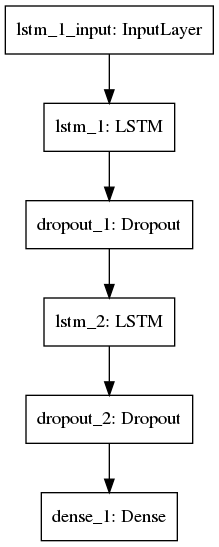

In [9]:
model = Sequential()

model.add(LSTM(30,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],6)))
model.add(Dropout(0.2))
model.add(LSTM(30,activation="relu",return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(6))
model.compile(optimizer="adam",loss="MSE", metrics=["accuracy"])
model.summary()
plot_model(model, to_file="model.png")

**Fitting model with 18 epoches and batch_size of 64
these numbers seems to be reasonable according to the result that we achieve also using callbacks to saving best model according to loss value**

In [10]:
checkpoint = ModelCheckpoint("model.h5", monitor = 'loss', save_best_only = True, mode = 'min')

In [11]:
%%time
model.fit(X_train, y_train, epochs=18, batch_size=64, verbose=1, callbacks=[checkpoint])

Epoch 1/18
24017/24017 [==============================] - 14s 573us/step - loss: 0.0091 - accuracy: 0.3612
Epoch 2/18
24017/24017 [==============================] - 14s 602us/step - loss: 0.0026 - accuracy: 0.5734
Epoch 3/18
24017/24017 [==============================] - 12s 497us/step - loss: 0.0018 - accuracy: 0.6940
Epoch 4/18
24017/24017 [==============================] - 12s 504us/step - loss: 0.0015 - accuracy: 0.7228
Epoch 5/18
24017/24017 [==============================] - 12s 518us/step - loss: 0.0013 - accuracy: 0.7389
Epoch 6/18
24017/24017 [==============================] - 12s 504us/step - loss: 0.0012 - accuracy: 0.7441
Epoch 7/18
24017/24017 [==============================] - 12s 506us/step - loss: 0.0011 - accuracy: 0.7566
Epoch 8/18
24017/24017 [==============================] - 13s 532us/step - loss: 0.0010 - accuracy: 0.7610
Epoch 9/18
24017/24017 [==============================] - 13s 547us/step - loss: 9.8287e-04 - accuracy: 0.7629
Epoch 10/18
24017/24017 [========

**Then we evaluate model with r2_score which computes the coefficient of determination.**

In [12]:
prediction = model.predict(X_test)
score = r2_score(y_test, prediction)
print("R^2 Score model = {}".format(score))

R^2 Score model = 0.9622555065761299


**And finally we plot the result to see how good our model predict test data.**

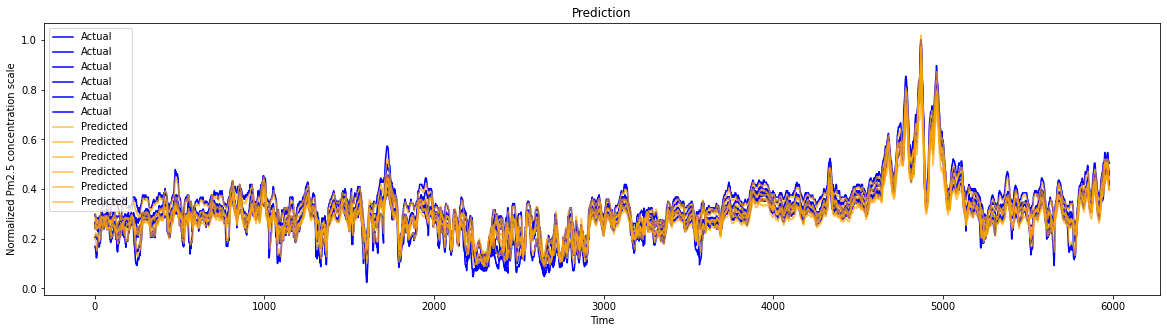

In [13]:
prediction = model.predict(X_test)
plt.figure(figsize=(20,5))
plt.plot(y_test, color='blue',label='Actual')
plt.plot(prediction, alpha=0.7, color='orange',label='Predicted')
plt.title("Prediction")
plt.xlabel('Time')
plt.ylabel('Normalized Pm2.5 concentration scale')
plt.legend()
plt.show()